# Generalities for DAEs and VAEs

* Import libraries
* Run on GPU if possible
* Create data loaders

In [22]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from IPython.display import Image, display
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 15]

# create directory to save results
!mkdir results

# script parameters
batch_size = 128
log_interval = 100

# run on GPU if possible
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

# create data loaders
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)

mkdir: cannot create directory ‘results’: File exists


# Neural Network classes

* Deterministic auto-encoder (DAE)
* Variational auto-encoder (VAE)


In [23]:
# Deterministic Auto-Encoder (DAE)
class DAE(nn.Module):

    # declare layers
    def __init__(self):
        super(DAE, self).__init__()
        self.fc1 = nn.Linear(784, 400)
        self.fc2 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    # encoder: one ReLU hidden layer of 400 nodes, one Linear output layer of 20 nodes
    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc2(h)

    # decoder: one ReLU hidden layer of 400 nodes, one sigmoid output layer of 784 nodes
    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    # forward: encoder followed by decoder
    def forward(self, x):
        z = self.encode(x.view(-1, 784))
        return self.decode(z)

# Variational Auto-Encoder (VAE)     
class VAE(nn.Module):

    # declare layers
    def __init__(self):
        super(VAE, self).__init__()
        # dummy assignment until this function is filled in
        self.fc1 = nn.Linear(784, 400)
        self.fc_mean = nn.Linear(400, 20)
        self.fc_log_variance = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    # Encoder: one ReLU hidden layer of 400 nodes, two Linear output layers of 20 nodes (means and log_variances)
    # Input: image (array of size 784)
    # Output: means (array of size 20), log_variances (array of size 20)
    def encode(self, x):
        # dummy assignment until this function is filled in
        h = F.relu(self.fc1(x))
        means = self.fc_mean(h)
        log_variances = self.fc_log_variance(h)
        return means, log_variances

    # Reparameterization:
    #
    # Let eps be samples from a Normal(0,1)
    # Input: means (array of size 20), log_variances (array of size 20)
    # Output: embedding (array of size 20 corresponding to means + eps * exponential(log_variances/2))
    def reparameterize(self, means, log_variances):
        # dummy assignment until this function is filled in
        eps = torch.randn(means.shape[0], 20).to(device)
        embedding = means + eps * torch.exp(log_variances / 2)
        return embedding

    # Decoder: one ReLU hidden layer of 400 nodes, one sigmoid output layer of 784 nodes
    # Input: embedding (array of size 20)
    # Output: probability of reconstructed image (array of size 784)
    def decode(self, z):
        # dummy assignment until this function is filled in
        h3 = F.relu(self.fc3(z))
        probabilties = torch.sigmoid(self.fc4(h3))
        return probabilties

    # Function forward: encoder, reparameterize, decoder
    # Input: image
    # Output: probability of reconstructed image, means, log_variances
    def forward(self, x):
        # dummy assignment until this function is filled in
        means, log_variances = self.encode(x.view(-1, 784))
        z = self.reparameterize(means, log_variances)
        probabilties = self.decode(z)
        return probabilties, means, log_variances

# Loss Functions

In [24]:
# DAE Loss Function
# Reconstruction loss: binary cross entropy
#
# Inputs:
#    reconstructed_x: reconstructed image
#    x: image
#
# Output:
#    BCE: binary cross entropy  
#
def dae_loss_function(reconstructed_x, x):
    BCE = F.binary_cross_entropy(reconstructed_x, x.view(-1, 784), reduction='sum')
    return BCE

# VAE Loss Function
# Reconstruction loss: binary cross entropy
# KL divergence loss: -0.5 * sum(1 + log_variances - means^2 - exp(log_variances))
#       see Appendix B from VAE paper:
#       Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
#       https://arxiv.org/abs/1312.6114
#
# Inputs: 
#    reconstructed_x: reconstructed image
#    x: image
#    means: array of size 20
#    log_variances: array of size 20
#
# Outputs:
#    total_loss: binary cross entropy + KL divergence (scalar)
#    BCE: binary cross entropy (scalar)
#
def vae_loss_function(reconstructed_x, x, means, log_variances):
    # dummy assignment until this function is filled in
    KL_divergence = -0.5 * torch.sum(1 + log_variances - torch.pow(means, 2) - torch.exp(log_variances))
    BCE = F.binary_cross_entropy(reconstructed_x, x.view(-1, 784), reduction='sum')
    total_loss = BCE + KL_divergence
    return total_loss, BCE


In [25]:
# Training

In [26]:
# DAE Training
#
# Inputs:
#    epoch: epoch #
#    model: DAE neural network
#    optimizer: DAE optimizer
#
# Outputs:
#    average_train_BCE: binary cross entropy (scalar)
#
def dae_train(epoch, model, optimizer):
    train_BCE = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch = model(data)
        loss = dae_loss_function(recon_batch, data)
        loss.backward()
        train_BCE += loss.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))
    average_train_BCE = train_BCE / len(train_loader.dataset)
    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, average_train_BCE))
    return average_train_BCE

# VAE Training
#
# Inputs:
#    epoch: epoch #
#    model: VAE neural network
#    optimizer: VAE optimizer
#
# Outputs:
#    average_train_loss: binary cross entropy + KL divergence (scalar)
#    average_train_BCE: binary cross entropy (scalar)
#
def vae_train(epoch, model, optimizer):
    # dummy assignment until this function is filled in
    train_BCE = 0
    total_train_BCE = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, means, log_variances = model(data)
        total_loss, loss = vae_loss_function(recon_batch, data, means, log_variances)
        loss.backward()
        total_train_BCE += total_loss.item()
        train_BCE += loss.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tTotal Loss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                total_loss.item() / len(data)))
    average_train_loss = total_train_BCE / len(train_loader.dataset)
    average_train_BCE = train_BCE / len(train_loader.dataset)
    print('====> Epoch: {} Total average loss: {:.4f}'.format(
          epoch, average_train_loss))
    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, average_train_BCE))
    return average_train_loss, average_train_BCE



# Testing

In [33]:
# DAE Test
#
# Inputs:
#    epoch: epoch #
#    model: DAE neural network
#
# Outputs:
#    average_test_BCE: binary cross entropy (scalar)
#
def dae_test(epoch, model):
    model.eval()
    test_BCE = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch = model(data)
            test_BCE += dae_loss_function(recon_batch, data).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(batch_size, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                         'results/reconstruction_' + str(epoch) + '.png', nrow=n)
                print('Sample of reconstructed images (top row are targets and bottom row are reconstructions)')
                display(Image('results/reconstruction_' + str(epoch) + '.png'))
    average_test_BCE = test_BCE / len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(average_test_BCE))
    return average_test_BCE

# VAE Test
#
# Inputs:
#    epoch: epoch #
#    model: VAE neural network
#
# Outputs:
#    average_test_loss: binary cross entropy + KL divergence (scalar)
#    average_test_BCE: binary cross entropy (scalar)
#
def vae_test(epoch, model):
    # dummy assignment until this function is filled in
    model.eval()
    total_test_BCE = 0
    test_BCE = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, means, log_variances = model(data)
            total_loss, loss = vae_loss_function(recon_batch, data, means, log_variances)
            test_BCE += loss.item()
            total_test_BCE += total_loss.item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(batch_size, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                         'results/reconstruction_' + str(epoch) + '.png', nrow=n)
                print('Sample of reconstructed images (top row are targets and bottom row are reconstructions)')
                display(Image('results/reconstruction_' + str(epoch) + '.png'))
    average_test_loss = total_test_BCE / len(test_loader.dataset)
    average_test_BCE = test_BCE / len(test_loader.dataset)
    print('====> Total test set loss: {:.4f}'.format(average_test_loss))
    print('====> Test set loss: {:.4f}'.format(average_test_BCE))
    return average_test_loss, average_test_BCE


# Main

Train Epoch: 1 [0/60000 (0%)]	Loss: 549.134460
Train Epoch: 1 [0/60000 (0%)]	Total Loss: 549.254272
Train Epoch: 1 [12800/60000 (21%)]	Loss: 162.013275
Train Epoch: 1 [12800/60000 (21%)]	Total Loss: 229.794052
Train Epoch: 1 [25600/60000 (43%)]	Loss: 132.277985
Train Epoch: 1 [25600/60000 (43%)]	Total Loss: 264.221161
Train Epoch: 1 [38400/60000 (64%)]	Loss: 121.772400
Train Epoch: 1 [38400/60000 (64%)]	Total Loss: 283.933655
Train Epoch: 1 [51200/60000 (85%)]	Loss: 117.754562
Train Epoch: 1 [51200/60000 (85%)]	Total Loss: 294.717773
====> Epoch: 1 Total average loss: 275.1847
====> Epoch: 1 Average loss: 146.9940
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


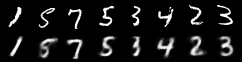

====> Total test set loss: 285.7047
====> Test set loss: 106.0403
Sample of generated images


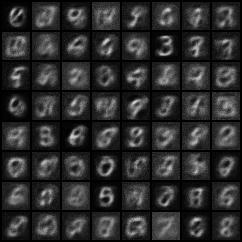



Train Epoch: 2 [0/60000 (0%)]	Loss: 109.310509
Train Epoch: 2 [0/60000 (0%)]	Total Loss: 285.251038
Train Epoch: 2 [12800/60000 (21%)]	Loss: 101.700470
Train Epoch: 2 [12800/60000 (21%)]	Total Loss: 295.728699
Train Epoch: 2 [25600/60000 (43%)]	Loss: 99.923218
Train Epoch: 2 [25600/60000 (43%)]	Total Loss: 317.734131
Train Epoch: 2 [38400/60000 (64%)]	Loss: 94.351929
Train Epoch: 2 [38400/60000 (64%)]	Total Loss: 317.954193
Train Epoch: 2 [51200/60000 (85%)]	Loss: 93.303078
Train Epoch: 2 [51200/60000 (85%)]	Total Loss: 339.976318
====> Epoch: 2 Total average loss: 315.1534
====> Epoch: 2 Average loss: 99.5241
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


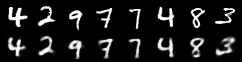

====> Total test set loss: 328.7070
====> Test set loss: 86.6568
Sample of generated images


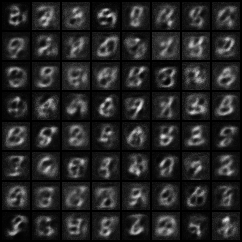



Train Epoch: 3 [0/60000 (0%)]	Loss: 90.076736
Train Epoch: 3 [0/60000 (0%)]	Total Loss: 324.049133
Train Epoch: 3 [12800/60000 (21%)]	Loss: 91.045135
Train Epoch: 3 [12800/60000 (21%)]	Total Loss: 362.196930
Train Epoch: 3 [25600/60000 (43%)]	Loss: 92.252121
Train Epoch: 3 [25600/60000 (43%)]	Total Loss: 351.004639
Train Epoch: 3 [38400/60000 (64%)]	Loss: 92.975266
Train Epoch: 3 [38400/60000 (64%)]	Total Loss: 374.364197
Train Epoch: 3 [51200/60000 (85%)]	Loss: 81.120094
Train Epoch: 3 [51200/60000 (85%)]	Total Loss: 350.480286
====> Epoch: 3 Total average loss: 349.1407
====> Epoch: 3 Average loss: 86.7693
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


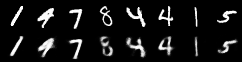

====> Total test set loss: 364.9068
====> Test set loss: 78.7384
Sample of generated images


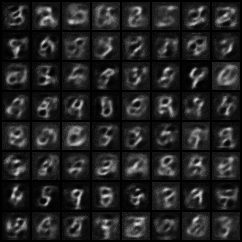



Train Epoch: 4 [0/60000 (0%)]	Loss: 80.316628
Train Epoch: 4 [0/60000 (0%)]	Total Loss: 363.957855
Train Epoch: 4 [12800/60000 (21%)]	Loss: 80.333511
Train Epoch: 4 [12800/60000 (21%)]	Total Loss: 369.770203
Train Epoch: 4 [25600/60000 (43%)]	Loss: 83.835892
Train Epoch: 4 [25600/60000 (43%)]	Total Loss: 368.853699
Train Epoch: 4 [38400/60000 (64%)]	Loss: 78.646095
Train Epoch: 4 [38400/60000 (64%)]	Total Loss: 380.303955
Train Epoch: 4 [51200/60000 (85%)]	Loss: 77.801865
Train Epoch: 4 [51200/60000 (85%)]	Total Loss: 379.857849
====> Epoch: 4 Total average loss: 368.7255
====> Epoch: 4 Average loss: 80.8042
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


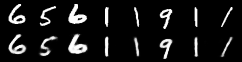

====> Total test set loss: 386.2599
====> Test set loss: 76.1780
Sample of generated images


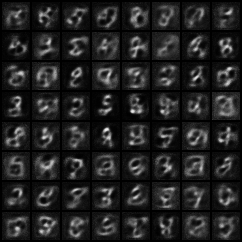



Train Epoch: 5 [0/60000 (0%)]	Loss: 77.127701
Train Epoch: 5 [0/60000 (0%)]	Total Loss: 379.709045
Train Epoch: 5 [12800/60000 (21%)]	Loss: 74.531067
Train Epoch: 5 [12800/60000 (21%)]	Total Loss: 378.447937
Train Epoch: 5 [25600/60000 (43%)]	Loss: 77.355988
Train Epoch: 5 [25600/60000 (43%)]	Total Loss: 373.424042
Train Epoch: 5 [38400/60000 (64%)]	Loss: 76.910416
Train Epoch: 5 [38400/60000 (64%)]	Total Loss: 381.755615
Train Epoch: 5 [51200/60000 (85%)]	Loss: 74.169563
Train Epoch: 5 [51200/60000 (85%)]	Total Loss: 364.092651
====> Epoch: 5 Total average loss: 382.4273
====> Epoch: 5 Average loss: 77.6896
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


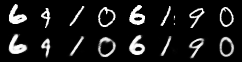

====> Total test set loss: 395.6374
====> Test set loss: 74.1091
Sample of generated images


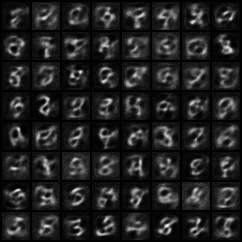



Train Epoch: 6 [0/60000 (0%)]	Loss: 76.159355
Train Epoch: 6 [0/60000 (0%)]	Total Loss: 412.112915
Train Epoch: 6 [12800/60000 (21%)]	Loss: 71.281036
Train Epoch: 6 [12800/60000 (21%)]	Total Loss: 379.847687
Train Epoch: 6 [25600/60000 (43%)]	Loss: 68.570457
Train Epoch: 6 [25600/60000 (43%)]	Total Loss: 365.688232
Train Epoch: 6 [38400/60000 (64%)]	Loss: 75.460304
Train Epoch: 6 [38400/60000 (64%)]	Total Loss: 392.603394
Train Epoch: 6 [51200/60000 (85%)]	Loss: 76.501625
Train Epoch: 6 [51200/60000 (85%)]	Total Loss: 370.987366
====> Epoch: 6 Total average loss: 391.3468
====> Epoch: 6 Average loss: 75.5999
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


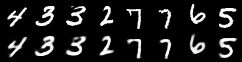

====> Total test set loss: 404.9053
====> Test set loss: 72.8602
Sample of generated images


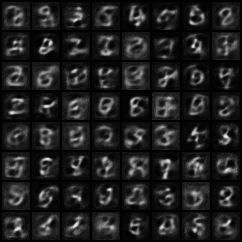



Train Epoch: 7 [0/60000 (0%)]	Loss: 73.290985
Train Epoch: 7 [0/60000 (0%)]	Total Loss: 397.347107
Train Epoch: 7 [12800/60000 (21%)]	Loss: 78.097443
Train Epoch: 7 [12800/60000 (21%)]	Total Loss: 371.641327
Train Epoch: 7 [25600/60000 (43%)]	Loss: 73.612122
Train Epoch: 7 [25600/60000 (43%)]	Total Loss: 393.874725
Train Epoch: 7 [38400/60000 (64%)]	Loss: 76.955261
Train Epoch: 7 [38400/60000 (64%)]	Total Loss: 418.080841
Train Epoch: 7 [51200/60000 (85%)]	Loss: 72.126221
Train Epoch: 7 [51200/60000 (85%)]	Total Loss: 399.621857
====> Epoch: 7 Total average loss: 397.3880
====> Epoch: 7 Average loss: 74.2166
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


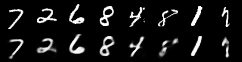

====> Total test set loss: 395.5425
====> Test set loss: 71.9167
Sample of generated images


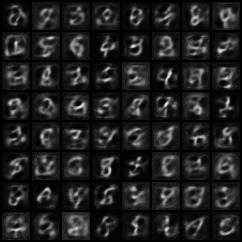



Train Epoch: 8 [0/60000 (0%)]	Loss: 73.322739
Train Epoch: 8 [0/60000 (0%)]	Total Loss: 384.075745
Train Epoch: 8 [12800/60000 (21%)]	Loss: 73.431839
Train Epoch: 8 [12800/60000 (21%)]	Total Loss: 388.295349
Train Epoch: 8 [25600/60000 (43%)]	Loss: 71.432541
Train Epoch: 8 [25600/60000 (43%)]	Total Loss: 381.349426
Train Epoch: 8 [38400/60000 (64%)]	Loss: 72.774780
Train Epoch: 8 [38400/60000 (64%)]	Total Loss: 423.321411
Train Epoch: 8 [51200/60000 (85%)]	Loss: 70.207741
Train Epoch: 8 [51200/60000 (85%)]	Total Loss: 410.374573
====> Epoch: 8 Total average loss: 402.4293
====> Epoch: 8 Average loss: 73.1555
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


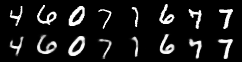

====> Total test set loss: 401.6865
====> Test set loss: 71.0527
Sample of generated images


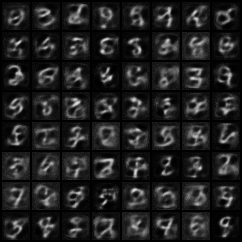



Train Epoch: 9 [0/60000 (0%)]	Loss: 70.997345
Train Epoch: 9 [0/60000 (0%)]	Total Loss: 394.271118
Train Epoch: 9 [12800/60000 (21%)]	Loss: 75.348358
Train Epoch: 9 [12800/60000 (21%)]	Total Loss: 427.797028
Train Epoch: 9 [25600/60000 (43%)]	Loss: 71.084335
Train Epoch: 9 [25600/60000 (43%)]	Total Loss: 407.573120
Train Epoch: 9 [38400/60000 (64%)]	Loss: 73.660034
Train Epoch: 9 [38400/60000 (64%)]	Total Loss: 399.825562
Train Epoch: 9 [51200/60000 (85%)]	Loss: 70.031006
Train Epoch: 9 [51200/60000 (85%)]	Total Loss: 404.015961
====> Epoch: 9 Total average loss: 406.6226
====> Epoch: 9 Average loss: 72.2658
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


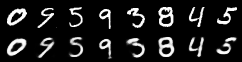

====> Total test set loss: 411.3129
====> Test set loss: 70.3888
Sample of generated images


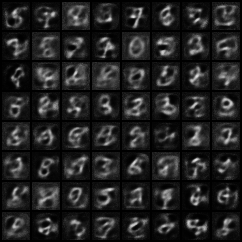



Train Epoch: 10 [0/60000 (0%)]	Loss: 73.718964
Train Epoch: 10 [0/60000 (0%)]	Total Loss: 411.737823
Train Epoch: 10 [12800/60000 (21%)]	Loss: 71.087944
Train Epoch: 10 [12800/60000 (21%)]	Total Loss: 394.478210
Train Epoch: 10 [25600/60000 (43%)]	Loss: 70.941086
Train Epoch: 10 [25600/60000 (43%)]	Total Loss: 404.983459
Train Epoch: 10 [38400/60000 (64%)]	Loss: 71.955139
Train Epoch: 10 [38400/60000 (64%)]	Total Loss: 417.938324
Train Epoch: 10 [51200/60000 (85%)]	Loss: 70.593277
Train Epoch: 10 [51200/60000 (85%)]	Total Loss: 410.836548
====> Epoch: 10 Total average loss: 408.6493
====> Epoch: 10 Average loss: 71.6252
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


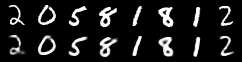

====> Total test set loss: 405.7256
====> Test set loss: 69.9615
Sample of generated images


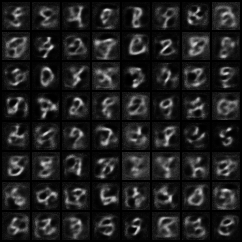

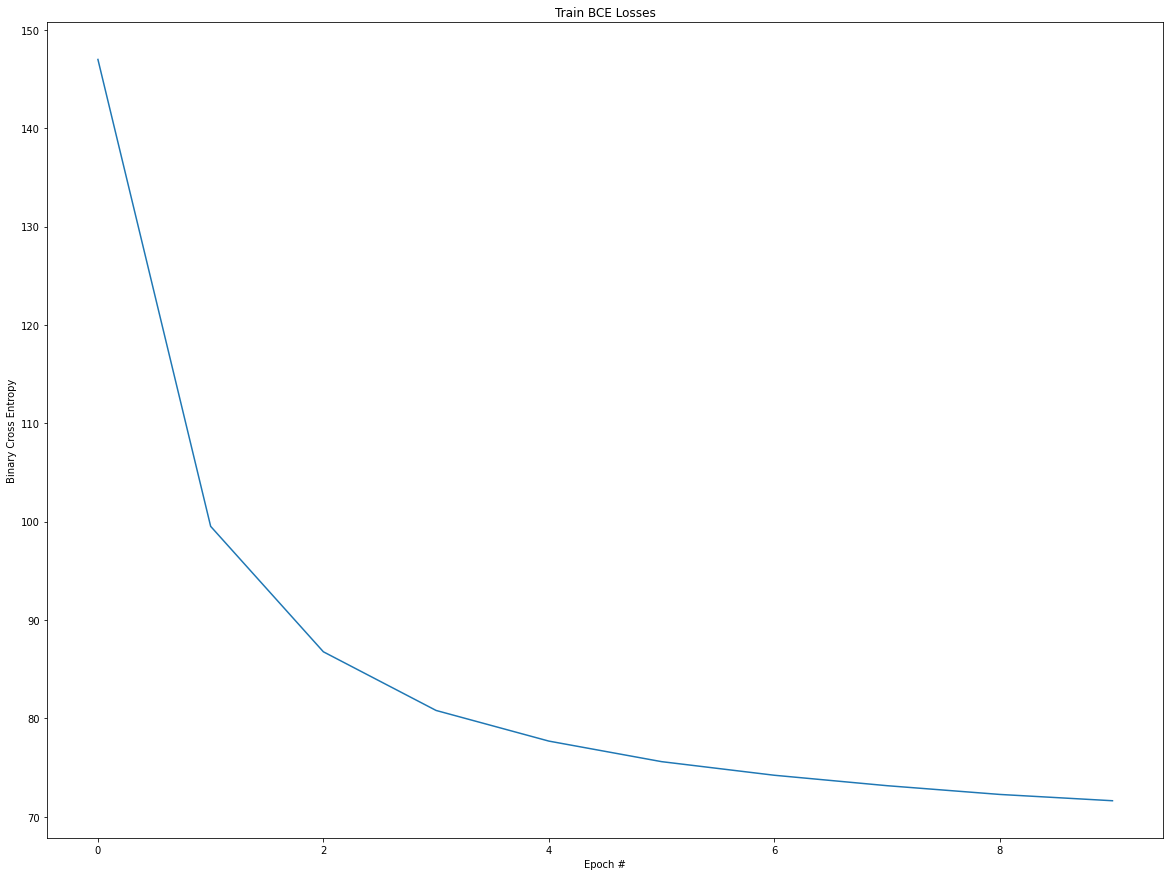

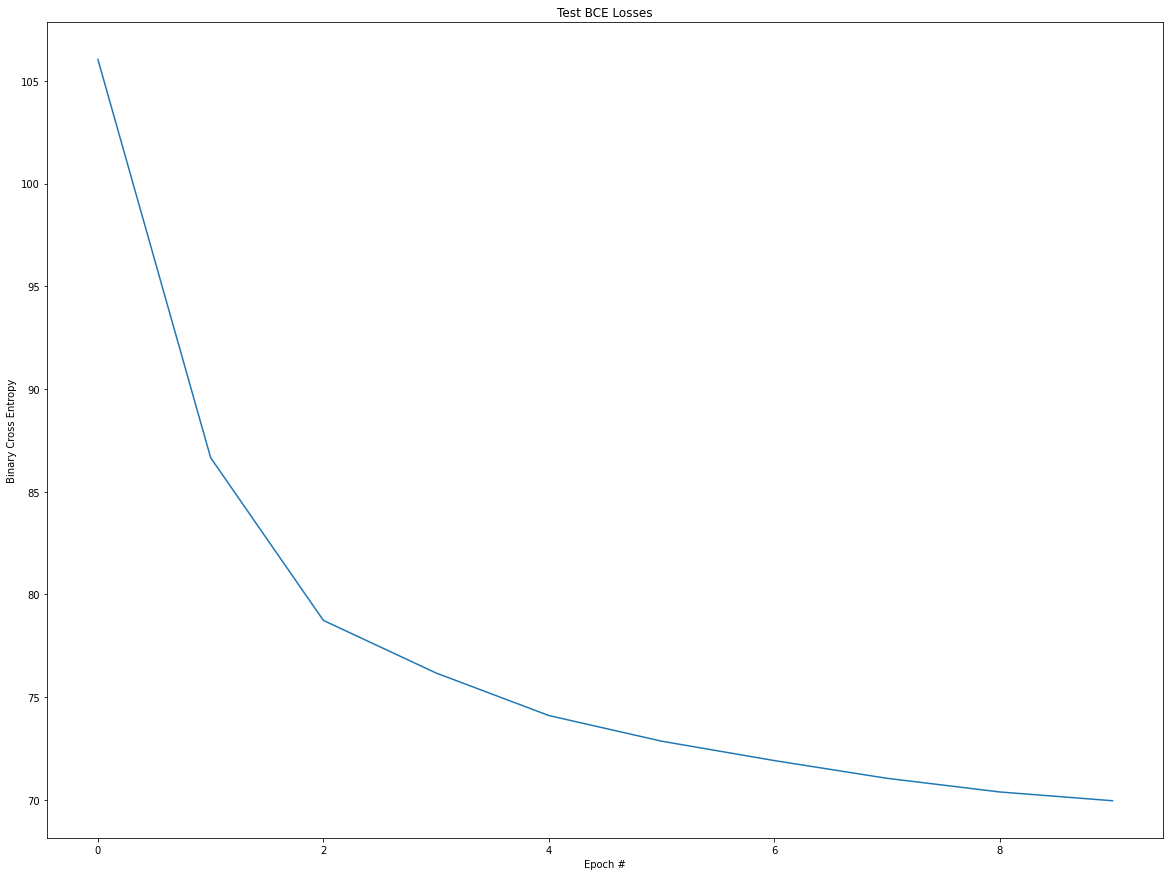

In [39]:
# train and test DAE
epochs = 10
dae_average_train_BCE = []
dae_average_test_BCE = []
dae_model = DAE().to(device)
dae_optimizer = optim.Adam(dae_model.parameters(), lr=1e-4)
for epoch in range(1, epochs + 1):
    average_train_BCE = dae_train(epoch, dae_model, dae_optimizer)
    dae_average_train_BCE.append(average_train_BCE)
    average_test_BCE = dae_test(epoch, dae_model)
    dae_average_test_BCE.append(average_test_BCE)
    with torch.no_grad():
        sample = torch.randn(64, 20).to(device)
        sample = dae_model.decode(sample).cpu()
        save_image(sample.view(64, 1, 28, 28),
                   'results/sample_' + str(epoch) + '.png')
        print('Sample of generated images')
        display(Image('results/sample_' + str(epoch) + '.png'))
        print('\n')

# train and test VAE
epochs = 10
vae_average_train_losses = []
vae_average_train_BCE = []
vae_average_test_losses = []
vae_average_test_BCE = []
vae_model = VAE().to(device)
vae_optimizer = optim.Adam(vae_model.parameters(), lr=1e-3)
# For Exercise 1.4
# vae_optimizer = optim.Adam(vae_model.parameters(), lr=1e-4)
# vae_optimizer = optim.SGD(vae_model.parameters(), lr=1e-4)
for epoch in range(1, epochs + 1):
    average_train_loss, average_train_BCE = vae_train(epoch, vae_model, vae_optimizer)
    vae_average_train_losses.append(average_train_loss)
    vae_average_train_BCE.append(average_train_BCE)
    average_test_loss, average_test_BCE = vae_test(epoch, vae_model)
    vae_average_test_losses.append(average_test_loss)
    vae_average_test_BCE.append(average_test_BCE)
    with torch.no_grad():
        sample = torch.randn(64, 20).to(device)
        sample = vae_model.decode(sample).cpu()
        save_image(sample.view(64, 1, 28, 28),
                   'results/sample_' + str(epoch) + '.png')
        print('Sample of generated images')
        display(Image('results/sample_' + str(epoch) + '.png'))
        print('\n')

# Plot Train BCE Losses
plt.plot(dae_average_train_BCE)
plt.plot(vae_average_train_BCE)
plt.title('Train BCE Losses')
plt.ylabel('Binary Cross Entropy')
plt.xlabel('Epoch #')
plt.legend(['DAE','VAE'], loc='upper right')
plt.show()

# Plot Test BCE Losses
plt.plot(dae_average_test_BCE)
plt.plot(vae_average_test_BCE)
plt.title('Test BCE Losses')
plt.ylabel('Binary Cross Entropy')
plt.xlabel('Epoch #')
plt.legend(['DAE','VAE'], loc='upper right')
plt.show()